In [1]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from matplotlib import pyplot as plt

from psychedelic_functions import _get_binned_spike_counts, _get_spike_times_in_interval

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [2]:
df_spikes = pd.read_pickle('data/spike_times.pkl')

In [3]:
df_timings = pd.read_csv('metadata/timings.csv').set_index('eid')

In [4]:
df_spikes = df_spikes[np.isin(df_spikes['eid'], df_timings.dropna().index)]

In [5]:
for i in [0, 1]:
    args = {'start': f'spontaneous_start_0{i}', 'stop': f'spontaneous_stop_0{i}'}
    for event in args.values():
        df_spikes[event] = df_spikes['eid'].apply(lambda x: df_timings.loc[x][event])
    
    df_spikes[f'spike_counts_spontaneous_0{i}'] = df_spikes.apply(_get_binned_spike_counts, **args, axis='columns')
    df_spikes[f'ff_spontaneous_0{i}'] = df_spikes[f'spike_counts_spontaneous_0{i}'].apply(lambda x: x.var() / x.mean())
    df_spikes[f'rate_spontaneous_0{i}'] = df_spikes[f'spike_counts_spontaneous_0{i}'].apply(lambda x: (x / 0.5).mean())
    
    df_spikes[f'spike_times_spontaneous_0{i}'] = df_spikes.apply(_get_spike_times_in_interval, **args, axis='columns')
    df_spikes[f'cv_spontaneous_0{i}'] = df_spikes[f'spike_times_spontaneous_0{i}'].apply(lambda x: np.diff(x).std() / np.diff(x).mean())

/tmp/ipykernel_459530/3901713389.py:7: RuntimeWarning: invalid value encountered in scalar divide
  df_spikes[f'ff_spontaneous_0{i}'] = df_spikes[f'spike_counts_spontaneous_0{i}'].apply(lambda x: x.var() / x.mean())
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_459530/3901713389.py:11: RuntimeWarning: Mean of empty slice.
  df_spikes[f'cv_spontaneous_0{i}'] = df_spikes[f'spike_times_spontaneous_0{i}'].apply(lambda x: np.diff(x).st

Median CV (baseline): 1.5412540156550079
Median CV (LSD): 1.7035915869136187
Wilcoxon test result: statistic=145835.0, p-value=1.5930628733204062e-11
Median CV diff: 0.08753946446637306


/tmp/ipykernel_459530/1429381361.py:28: RuntimeWarning: All-NaN slice encountered
  df_cv = df_spikes.groupby('acronym').apply(lambda x: np.nanmedian(x['cv_spontaneous_01'] - x['cv_spontaneous_00'])).sort_values(ascending=False)
/tmp/ipykernel_459530/1429381361.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cv = df_spikes.groupby('acronym').apply(lambda x: np.nanmedian(x['cv_spontaneous_01'] - x['cv_spontaneous_00'])).sort_values(ascending=False)


Text(0, 0.5, 'CV (LSD - baseline)')

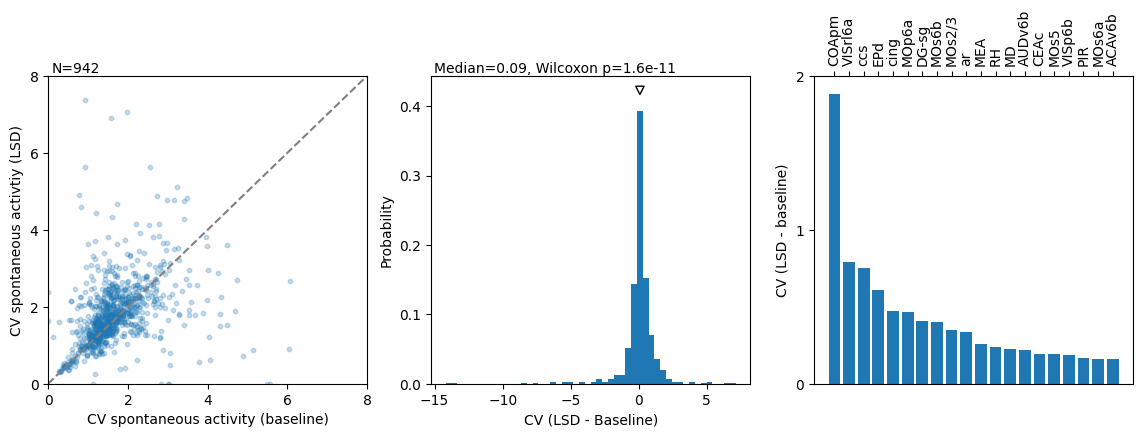

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].scatter(df_spikes['cv_spontaneous_00'], df_spikes['cv_spontaneous_01'], s=10, alpha=0.25)
axs[0].plot([0, 8], [0, 8], color='gray', ls='--')
axs[0].text(0.01, 1.01, f'N={len(df_spikes)}', transform=axs[0].transAxes)
axs[0].set_xticks([0, 2, 4, 6, 8])
axs[0].set_yticks([0, 2, 4, 6, 8])
axs[0].set_xlabel('CV spontaneous activity (baseline)')
axs[0].set_ylabel('CV spontaneous activtiy (LSD)')
axs[0].set_xlim([0, 8])
axs[0].set_ylim([0, 8])

print("Median CV (baseline):", np.nanmedian(df_spikes['cv_spontaneous_00']))
print("Median CV (LSD):", np.nanmedian(df_spikes['cv_spontaneous_01']))


diff = df_spikes['cv_spontaneous_01'] - df_spikes['cv_spontaneous_00']
stat, p_value = wilcoxon(diff, nan_policy='omit')
print(f"Wilcoxon test result: statistic={stat}, p-value={p_value}")
print("Median CV diff:", np.nanmedian(diff))
counts, bins, _ = axs[1].hist(diff, bins=50, weights=np.ones_like(diff)/len(diff))
axs[1].scatter(np.nanmedian(diff), counts.max() + 0.03, marker='v', fc='none', ec='black')
axs[1].text(0.01, 1.01, f'Median={np.nanmedian(diff):.2f}, Wilcoxon p={p:.1e}', transform=axs[1].transAxes)
axs[1].set_xlabel('CV (LSD - Baseline)')
axs[1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axs[1].set_ylabel('Probability')


df_cv = df_spikes.groupby('acronym').apply(lambda x: np.nanmedian(x['cv_spontaneous_01'] - x['cv_spontaneous_00'])).sort_values(ascending=False)

axs[2].bar(np.arange(20), df_cv.head(20))
axs[2].set_xticks(np.arange(20), df_cv.head(20).index.tolist(), rotation=90)
axs[2].xaxis.tick_top()
axs[2].set_yticks([0, 1, 2], [0, 1, 2], rotation=0)
axs[2].set_ylabel('CV (LSD - baseline)')

Median log(rate) (baseline): 0.6749430653609538
Median log(rate) (LSD): 0.786958775695377
Wilcoxon test result: statistic=167463.0, p-value=1.5930628733204062e-11
Median log(rate) diff: 0.10834207754434133


/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_459530/3331332869.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cv = df_spikes.groupby('acronym').apply(lambda x: np.nanmedian(x['lograte_spontaneous_01'] - x['lograte_spontaneous_00'])).sort_values(ascending=False)


Text(0, 0.5, 'log(rate) (LSD - baseline)')

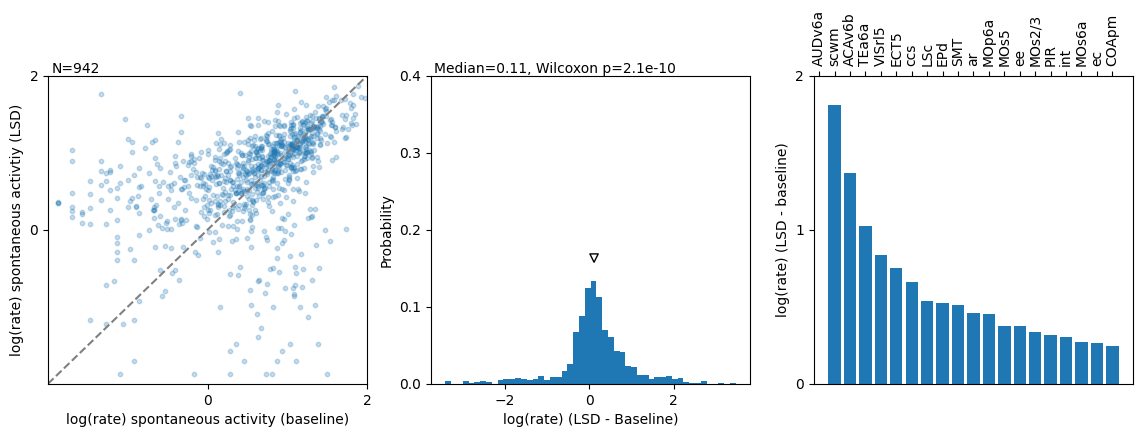

In [9]:
df_spikes['lograte_spontaneous_00'] = np.log10(df_spikes['rate_spontaneous_00'])
df_spikes['lograte_spontaneous_01'] = np.log10(df_spikes['rate_spontaneous_01'])

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].scatter(df_spikes['lograte_spontaneous_00'], df_spikes['lograte_spontaneous_01'], s=10, alpha=0.25)
axs[0].plot([-2, 2], [-2, 2], color='gray', ls='--')
axs[0].text(0.01, 1.01, f'N={len(df_spikes)}', transform=axs[0].transAxes)
axs[0].set_xticks([0, 2, 4, 6, 8])
axs[0].set_yticks([0, 2, 4, 6, 8])
axs[0].set_xlabel('log(rate) spontaneous activity (baseline)')
axs[0].set_ylabel('log(rate) spontaneous activtiy (LSD)')
axs[0].set_xlim([-2, 2])
axs[0].set_ylim([-2, 2])

print("Median log(rate) (baseline):", np.nanmedian(df_spikes['lograte_spontaneous_00']))
print("Median log(rate) (LSD):", np.nanmedian(df_spikes['lograte_spontaneous_01']))


diff = df_spikes['lograte_spontaneous_01'] - df_spikes['lograte_spontaneous_00']
stat, p = wilcoxon(diff, nan_policy='omit')
print(f"Wilcoxon test result: statistic={stat}, p-value={p_value}")
print("Median log(rate) diff:", np.nanmedian(diff))
counts, bins, _ = axs[1].hist(diff[~np.isin(diff, [np.inf, -np.inf])], bins=50, weights=np.ones_like(diff[~np.isin(diff, [np.inf, -np.inf])])/len(diff[~np.isin(diff, [np.inf, -np.inf])]))
axs[1].scatter(np.nanmedian(diff), counts.max() + 0.03, marker='v', fc='none', ec='black')
axs[1].text(0.01, 1.01, f'Median={np.nanmedian(diff):.2f}, Wilcoxon p={p:.1e}', transform=axs[1].transAxes)
axs[1].set_xlabel('log(rate) (LSD - Baseline)')
axs[1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axs[1].set_ylabel('Probability')


df_cv = df_spikes.groupby('acronym').apply(lambda x: np.nanmedian(x['lograte_spontaneous_01'] - x['lograte_spontaneous_00'])).sort_values(ascending=False)

axs[2].bar(np.arange(20), df_cv.head(20))
axs[2].set_xticks(np.arange(20), df_cv.head(20).index.tolist(), rotation=90)
axs[2].xaxis.tick_top()
axs[2].set_yticks([0, 1, 2], [0, 1, 2], rotation=0)
axs[2].set_ylabel('log(rate) (LSD - baseline)')